# Chapter 22
Bill Henderson
# Working with non-Normal distributions and the generalized linear model


Up to now, we have only worked with **numeric variables**. However, **categorical variables** are extremely common. In fact, most real-world data science problems involve one or more categorical variables. Indeed, some types of analysis involve only categorical variables. For examine, in natural language processing, all variables are categorical in the form of words or phrases. 

Machine learning models can have categorical variables as features. But, most models require numeric predictor variables. The question is, how can we transform categorical variables into numeric variables?  

In this notebook you will be introduced to working with categorical variables as features in regression models. The methods explored apply to most any machine learning model.  

## Preparing the Data Set

In this section we will prepare the data set we will use in this notebook. As a first step, execute the code in the cell below to import the required packages.

In [36]:
import pandas as pd
import numpy as np
import numpy.random as nr
import statsmodels.api as sm
import statsmodels.formula.api as smf  
from statsmodels.graphics.regressionplots import influence_plot, plot_regress_exog
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, StandardScaler
from patsy import dmatrices
from sklearn import metrics
import contextlib
import io

%matplotlib inline
sns.set(style='ticks', palette='Set2')

Execute the cell below to perform load the dataset into a data frame and examine the data types of the columns. 

In [37]:
auto_data = pd.read_csv('../data/AutoPricesClean.csv')
auto_data.dtypes                      

Unnamed: 0             int64
symboling              int64
normalized_losses     object
make                  object
fuel_type             object
aspiration            object
num_of_doors          object
body_style            object
drive_wheels          object
engine_location       object
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight            int64
engine_type           object
num_of_cylinders      object
engine_size            int64
fuel_system           object
bore                 float64
stroke               float64
compression_ratio    float64
horsepower             int64
peak_rpm               int64
city_mpg               int64
highway_mpg            int64
price                  int64
dtype: object

There are a number of numeric variables and categorical variables, of type `object`.

Next, execute the code in the cell below to do the following:   

- Remove the first 3 columns of the data frame. 
- Standardize the numeric columns of the data frame, except for the last 3 we can use as labels.  
- Examine the head of the data frame.   

In [38]:
## Get a list of columns that are not of type object   
auto_data.drop(auto_data.columns[:3], axis=1, inplace=True)
numeric_columns = [col for col_type,col in zip(auto_data.iloc[:,:-3].dtypes,auto_data.iloc[:,:-3].columns) if col_type in ['int64','float64']]
auto_data.loc[:,numeric_columns] = StandardScaler().fit_transform(auto_data.loc[:,numeric_columns])
auto_data.head()

/var/folders/yx/p_q7lg1d7l9gxgp19507kcr00000gr/T/ipykernel_87442/2301213151.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.02101769 -0.02101769  0.50442456 -0.4241752   0.50633526 -0.09935635
  0.54454924  0.75472615  1.00693843 -0.31335465 -0.31335465  0.28851556
  0.39360402  0.94770675  1.2820791   1.56868396  1.80752135 -2.04635874
 -1.30882889 -1.24195442 -1.30500749 -1.30500749 -0.82351131 -1.13113387
 -1.08909849 -1.08909849 -0.70313727 -0.04585678  0.48149617 -1.61645144
 -1.41391734 -1.37952475 -1.18272274 -1.15215156 -1.04897381 -1.02222402
 -0.61715581 -0.51588876 -0.48722827 -0.35730073 -0.17960572 -0.50824596
 -0.4241752   0.33437234  2.87942355  2.87942355  2.65778245 -1.2782577
 -1.25915071 -1.24959721 -1.17316925 -1.16361575 -0.33246164 -0.28469417
 -0.33246164 -0.28469417 -0.2216411  -0.25603368  0.2120876   0.26940857
  1.82662834  2.27564263  1.78841436  2.31385661  2.25653564  2.1514471

,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,alfa-romero,gas,std,two,convertible,rwd,front,-1.683439,-0.438504,-0.839749,...,0.049883,mpfi,0.518555,-1.820278,-0.294933,0.204599,-0.213003,21,27,13495
1,alfa-romero,gas,std,two,convertible,rwd,front,-1.683439,-0.438504,-0.839749,...,0.049883,mpfi,0.518555,-1.820278,-0.294933,0.204599,-0.213003,21,27,16500
2,alfa-romero,gas,std,two,hatchback,rwd,front,-0.718803,-0.245646,-0.181548,...,0.582216,mpfi,-2.394771,0.701202,-0.294933,1.342993,-0.213003,19,26,16500
3,audi,gas,std,four,sedan,fwd,front,0.147735,0.188283,0.147553,...,-0.458253,mpfi,-0.514016,0.477780,-0.048122,-0.033670,0.857502,24,30,13950
4,audi,gas,std,four,sedan,4wd,front,0.082336,0.188283,0.241582,...,0.195065,mpfi,-0.514016,0.477780,-0.541744,0.310496,0.857502,18,22,17450


Our goal with these data is to model the city MPG. Therefore, we will start with displaying a graph of the city MPG vs. curb weight for the two fuel types. Execute the code in the cell below and examine the  

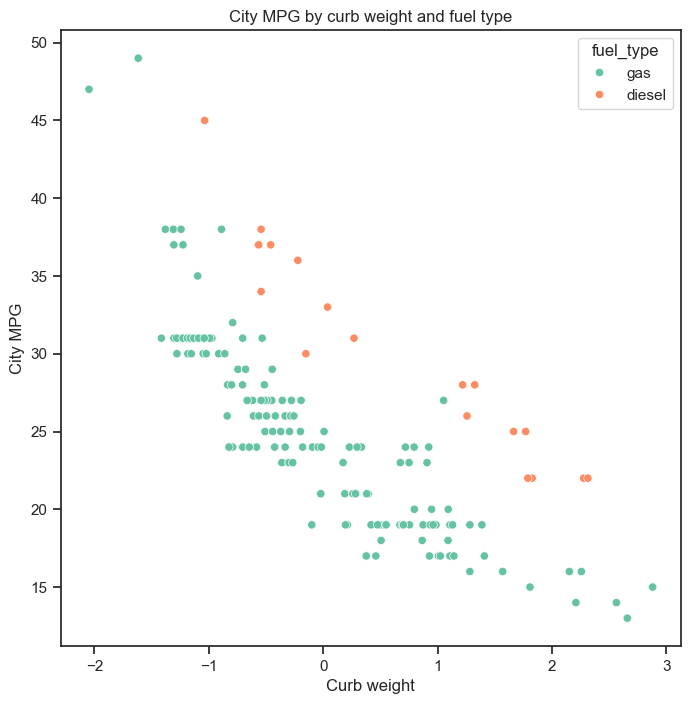

In [39]:
def plot_auto(x='curb_weight', y='city_mpg', hue='fuel_type', 
              title = 'City MPG by curb weight and fuel type', 
              xlabel='Curb weight', ylabel='City MPG',
              data=auto_data):
    fig,ax = plt.subplots(figsize=(8,8))
    sns.scatterplot(x=x, y=y, hue=hue, data=data);
    ax.set_title(title);
    ax.set_xlabel(xlabel);
    ax.set_ylabel(ylabel);
    return ax
    
_=plot_auto()    

## Categorical Variables and the Model Matrix

Most machine learning models can only work with numeric variables. Therefore, we need to encode the categorical variables into one or more numeric variables. The common approach is to convert the categorical variable to a set of binary **dummy variables** or **indicator variables**. We call this process **one-hot encoding** since only one of the dummy variables will be encoded as a 1 for each category or level of the variable. 

We will work with the Python [patsy](https://patsy.readthedocs.io/en/latest/quickstart.html) package which creates **design matrices** from Pandas data frames. Patsy creates the design matrices using the, by now familiar, R-style modeling [formulas](https://patsy.readthedocs.io/en/latest/formulas.html). These design matrices can be used directly in statsmodels or scikit-learn models. 

> **Note:** In this lesson we will use the term design matrices. However, you often see the term **model matrices**. Don't be confused! These terms mean the same thing.

### Design matrix with an intercept term

To start our exploration of how model matrices are constructed we will start with an example using only numeric variables. We will use the [dmatrices](https://patsy.readthedocs.io/en/latest/API-reference.html) function from the Patsy package, which returns both the feature and label matrices. A model formula is used to define the model created by the matrices returned by dmatricies. Execute the code in the cell below to construct the label and design matrices for the model formula shown and examine the results. 

In [40]:
print('Unique values of drive wheels = ' + str(auto_data.drive_wheels.unique()))
print('Unique values of body style = ' + str(auto_data.body_style.unique()))
formula = 'city_mpg ~ C(body_style)'
Y, X = dmatrices(formula, data=auto_data)
print('\nHead of label matrix \n{}\n'.format(Y[:5]))
print('Head design matrix \n{}'.format(X[:10]))

Unique values of drive wheels = ['rwd' 'fwd' '4wd']
Unique values of body style = ['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']

Head of label matrix 
[[21.]
 [21.]
 [19.]
 [24.]
 [18.]]

Head design matrix 
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0.]]


The label array, $Y$, looks much as you might expect. A one dimensional array of label values.  

The columns of the feature matrix might surprise you.  The first column is all 1's. This is the feature column for the **intercept term**. There are 4 containing dummy variables encoding the body style.

But notice that first two rows have only 0s for the dummy variables? How can this be? It turns out the intercept term is the mean of the first category of `body_style`. The other columns represent **contrasts** between the intercept and the **effect size** of the other categories. 

###  Design matrices without an intercept term 

We may not always want an intercept term. Patsy allows us to build a design matrix without an intercept term by including -1 in the formula. Execute the code in the cell below which does just this.     

In [41]:
Y, X = dmatrices('city_mpg ~ -1 + C(body_style)', data=auto_data)
print('Head of label matrix \n{}\n'.format(Y[:10]))
print('Design matrix \n{}'.format(X[:10]))

Head of label matrix 
[[21.]
 [21.]
 [19.]
 [24.]
 [18.]
 [19.]
 [19.]
 [19.]
 [17.]
 [23.]]

Design matrix 
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


The result is an array with 5 dummy variables, representing the 5 levels of the categorical variable. There is no longer an intercept column. 

Each of the levels of the categorical variable are now represented by a dummy variable. These dummy variables now represent the means for each level, not the contrasts. The feature matrix no longer has a column of 1s. By not using contrasts, the need for an intercept term is eliminated. 

We can test that this design matrix is **orthogonal**. By orthogonal, we mean that each dummy variable is not linearly dependent on any other. An orthogonal design matrix has several advantages. First, the inverse of the covariance matrix is guaranteed to exist. Second, we can directly interpret the model coefficients in terms of the response to the values of the predictor variables.  

The code in the cell below demonstrates the orthogonality of the design matrix by taking the dot products of every pairwise combination. Recall that the dot product between orthogonal vectors is zero. Execute this code and examine the results. 

In [42]:
from itertools import combinations
for i,j in combinations(range(5), 2):
    print('For columns {0:1d} and {1:1d} the dot product = {2:3.2f}'.format(i,j,np.dot(X[:,i],X[:,j])))

For columns 0 and 1 the dot product = 0.00
For columns 0 and 2 the dot product = 0.00
For columns 0 and 3 the dot product = 0.00
For columns 0 and 4 the dot product = 0.00
For columns 1 and 2 the dot product = 0.00
For columns 1 and 3 the dot product = 0.00
For columns 1 and 4 the dot product = 0.00
For columns 2 and 3 the dot product = 0.00
For columns 2 and 4 the dot product = 0.00
For columns 3 and 4 the dot product = 0.00


## Design Matrices with Mixed Type Variables

It is also possible to create design matrices with both categorical variables and continuous numeric variables. The numeric variables must be normalized to be on the same scale as the dummy variables.      

The resulting design matrix, uses the means of the levels of a categorical variable as the model coefficients. In other words, these coefficients represent the value for each level rather than contrasts with an intercept.    

Execute the code in the cell below to create a design matrix with no intercept term with categorical variable `body_style` and normalized continuous variables `engine_size` and `curb_weight`, with no intercept. 

In [43]:
Y, X = dmatrices('city_mpg ~ -1 + C(body_style) + curb_weight + engine_size', data=auto_data)
print('Head of label matrix \n{}\n'.format(Y[:5]))
print('Design matrix \n{}'.format(np.round(X[:5], 4)))

Head of label matrix 
[[21.]
 [21.]
 [19.]
 [24.]
 [18.]]

Design matrix 
[[ 1.      0.      0.      0.      0.     -0.021   0.0499]
 [ 1.      0.      0.      0.      0.     -0.021   0.0499]
 [ 0.      0.      1.      0.      0.      0.5044  0.5822]
 [ 0.      0.      0.      1.      0.     -0.4242 -0.4583]
 [ 0.      0.      0.      1.      0.      0.5063  0.1951]]


There are 7 columns in this design matrix. The first 5 columns are the dummy variables for the categorical variables for the contrasts of the levels. The last two columns are the values of the normalized numeric columns.   

One question you could ask, is if the columns of the design matrix are orthogonal? Execute the code in the cell below to find out.     

In [44]:
for i,j in combinations(range(7), 2):
    print('For columns {0:1d} and {1:1d} the dot product = {2:3.2f}'.format(i,j,np.dot(X[:,i],X[:,j])))

For columns 0 and 1 the dot product = 0.00
For columns 0 and 2 the dot product = 0.00
For columns 0 and 3 the dot product = 0.00
For columns 0 and 4 the dot product = 0.00
For columns 0 and 5 the dot product = 2.78
For columns 0 and 6 the dot product = 4.24
For columns 1 and 2 the dot product = 0.00
For columns 1 and 3 the dot product = 0.00
For columns 1 and 4 the dot product = 0.00
For columns 1 and 5 the dot product = 3.85
For columns 1 and 6 the dot product = 9.35
For columns 2 and 3 the dot product = 0.00
For columns 2 and 4 the dot product = 0.00
For columns 2 and 5 the dot product = -29.36
For columns 2 and 6 the dot product = -19.55
For columns 3 and 4 the dot product = 0.00
For columns 3 and 5 the dot product = 12.01
For columns 3 and 6 the dot product = 8.54
For columns 4 and 5 the dot product = 10.72
For columns 4 and 6 the dot product = -2.58
For columns 5 and 6 the dot product = 167.23


Examine the results above. The dummy variables are orthogonal as they should be. However, the dummy variables are not orthogonal to the numeric variables. Further, the numeric columns are not orthogonal.          

> **Exercise 22-1:** To better understand how the encoding of the dummy variables as contrasts works do the following:       
> 1. Define and fit an ols model of `city_mpg` by `fuel_type + curb_weight + curb_weight^2` using the [statsmodels.formula.api.ols](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html) function. Make sure you wrap the categorical variable in the `C()` operator and use the `I()` operator for the power term.     
> 2. Print the summary of this model.    

In [45]:
## Put your code below
formula = 'city_mpg ~ C(fuel_type) + curb_weight + I(curb_weight**2)'
city_mpg_ols = smf.ols(formula, data=auto_data).fit()

city_mpg_ols.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               city_mpg   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     365.9
Date:                Sun, 27 Oct 2024   Prob (F-statistic):           6.77e-79
Time:                        16:08:31   Log-Likelihood:                -452.08
No. Observations:                 195   AIC:                             912.2
Df Residuals:                     191   BIC:                             925.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              32.3655      0.594     54.484      0.000      31.194      33.537
C(fuel_type)[T.gas]    -9.2490      0.602    -15.373      0.000     -10.436      -8.062
curb_weight            -6.4280      0.207    -31.095      0.000      -6.836      -6.020
I(curb_weight ** 2)     1.3092      0.148      8.868      0.000       1.018       1.600
==============================================================================
Omnibus:                       51.333   Durbin-Watson:                   1.569
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.425
Skew:                           1.123   Prob(JB):                     6.46e-30
Kurtosis:                       6.392   Cond. No.                         9.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Answer the following questions:   
> 1. Notice that there is 1 dummy variable representing 2 possible values. Which category of this variable is represented by the intercept term?     
> 2. Which of the parameters do you consider to be significant and why? 
> 3. What does the contrast variable tell you about the average city MPG for these categories and why?    
> 4. Based on adjusted $R^2$ and F-statistic does this model explain any of the variance of the city MPG?  

> **Answers:**      
> 1. The intercept represents the diesel category.    
> 2. All four parameters are significant since the p-value is very low an the     
> 3. The contrast variable tells us that the average gas vehicle gets 9.25 less city MPG than the average diesel vehicle.  
> 4. Our adjusted $R^2$ is pretty close to 1 and our F-statistic is relatively high, I would say this model does a good job of explaining the variance of city MPG.    

>**Exercise 22-2:** You will now investigate how dropping the intercept term changes the behavior and interpretation of the model coefficients by doing the following:
     
> 1. Define and fit an ols model of `city_mpg` by `fuel_type + curb_weight + curb_weight^2` with no intercept using the `ols` function from `statsmodels.formula.api`. Name your model `city_mpg_ols_no_intercept`. Make sure you wrap the categorical variable in the `C()` operator.   
> 2. Print the summary of this model.    

In [46]:
## Put your code below
formula = 'city_mpg ~ C(fuel_type) + curb_weight + I(curb_weight**2) -1'
city_mpg_ols_no_intercept = smf.ols(formula, data=auto_data).fit()
# city_mpg_ols_no_intercept_fit = city_mpg_ols_no_intercept.fit()
city_mpg_ols_no_intercept.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               city_mpg   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     365.9
Date:                Sun, 27 Oct 2024   Prob (F-statistic):           6.77e-79
Time:                        16:08:31   Log-Likelihood:                -452.08
No. Observations:                 195   AIC:                             912.2
Df Residuals:                     191   BIC:                             925.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
C(fuel_type)[diesel]    32.3655      0.594     54.484      0.000      31.194      33.537
C(fuel_type)[gas]       23.1165      0.237     97.393      0.000      22.648      23.585
curb_weight             -6.4280      0.207    -31.095      0.000      -6.836      -6.020
I(curb_weight ** 2)      1.3092      0.148      8.868      0.000       1.018       1.600
==============================================================================
Omnibus:                       51.333   Durbin-Watson:                   1.569
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.425
Skew:                           1.123   Prob(JB):                     6.46e-30
Kurtosis:                       6.392   Cond. No.                         6.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> 3. Next, run the code in the cell below to display diagnostic plots for the model.  

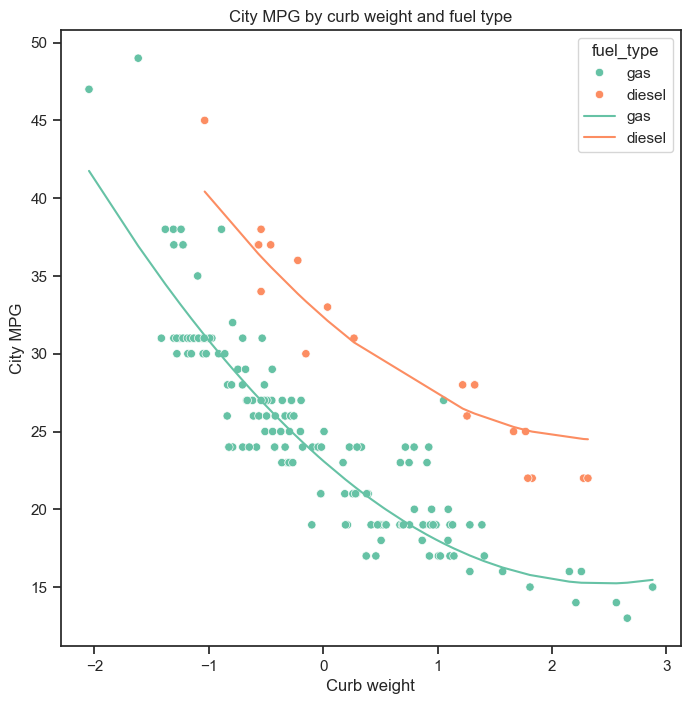

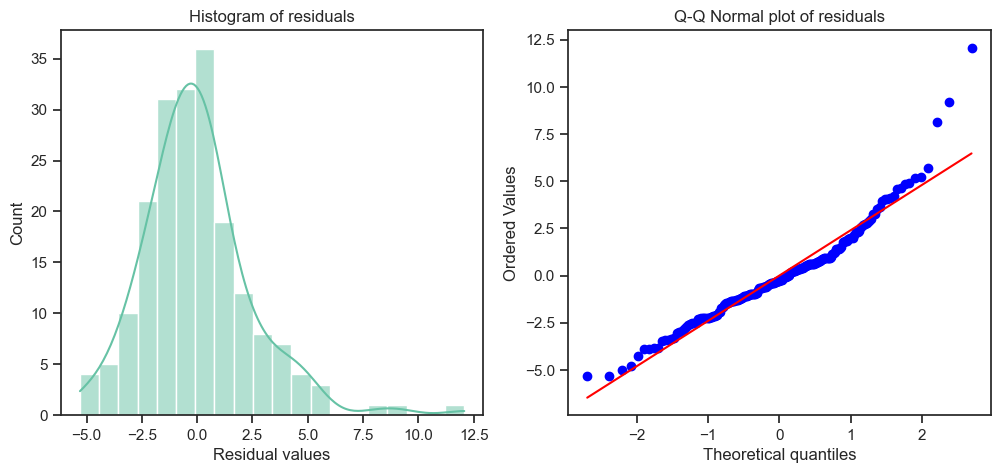

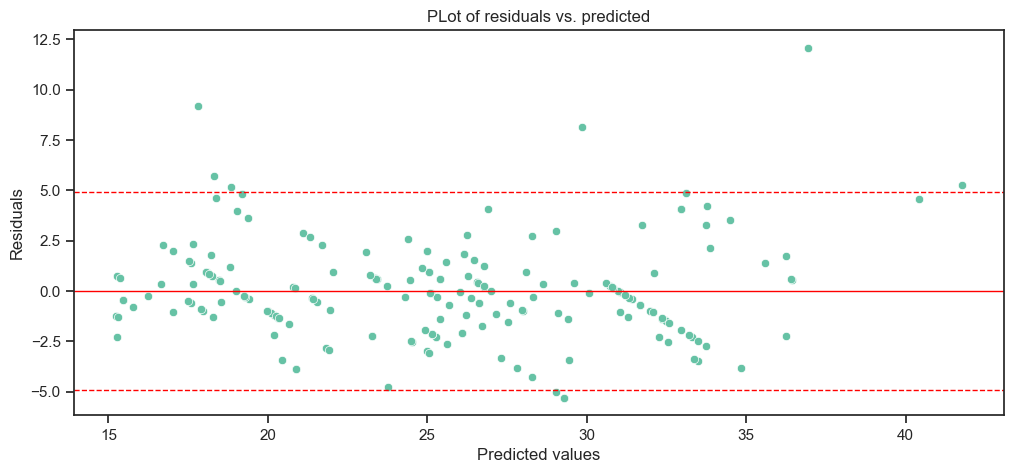

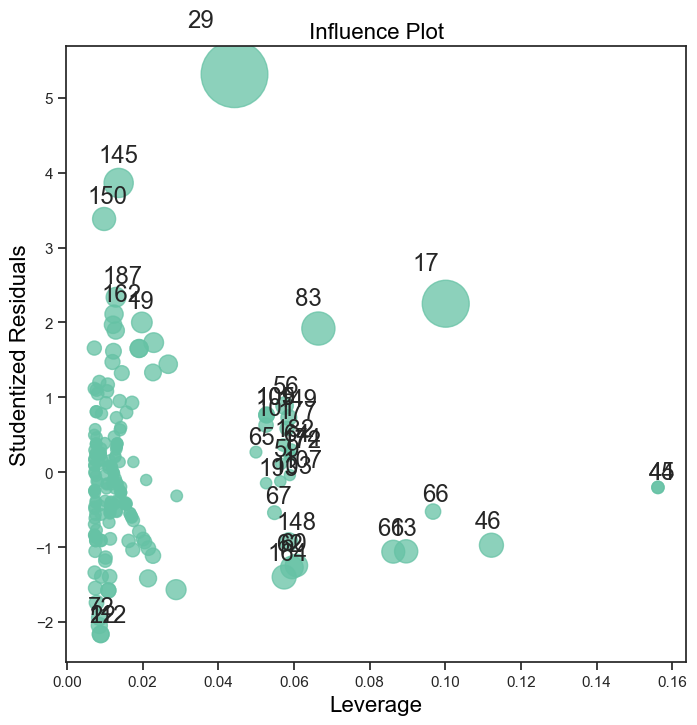

In [47]:
def plot_resid_dist(resids):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    ## Plot a histogram
    sns.histplot(resids, bins=20, kde=True, ax=ax[0])
    ax[0].set_title('Histogram of residuals')
    ax[0].set_xlabel('Residual values')
    ## Plot the Q-Q Normal plot
    ss.probplot(resids, plot = ax[1])
    ax[1].set_title('Q-Q Normal plot of residuals')
    plt.show()
    
def residual_plot(df, predicted='predicted', resids='resids'):
    fig,ax = plt.subplots(figsize=(12,5))
    RMSE = np.std(df.loc[:,resids])
    sns.scatterplot(x=predicted, y=resids, data=df, ax=ax)
    ax.axhline(0.0, color='red', linewidth=1.0)
    ax.axhline(2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    ax.axhline(-2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    ax.set_title('PLot of residuals vs. predicted')
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('Residuals')
    plt.show()    

auto_data.loc[:,'predicted'] = city_mpg_ols_no_intercept.predict(auto_data)
auto_data.loc[:,'resids'] = np.subtract(auto_data.loc[:,'city_mpg'], auto_data.loc[:,'predicted'])
ax = plot_auto()
sns.lineplot(x='curb_weight', y='predicted', hue='fuel_type', data=auto_data, ax=ax)

plot_resid_dist(auto_data.resids)
residual_plot(auto_data) 

fig,ax = plt.subplots(figsize=(8,8))
_=influence_plot(city_mpg_ols_no_intercept, ax=ax)

> 4. Notice there are some high leverage points associated with large residual values. Create and execute code to print the `make`, `city_mpg`, `fuel_type`, `curb_weight`, and `resids` columns for the 4 observations with the highest leverage in descending order of influence. The highest influence observations have the largest marker size.    

In [48]:
## Your code goes here
cols = ['make','city_mpg','fuel_type','curb_weight','resids']
high_points = [17,46,44,45]
auto_data.loc[auto_data.index.get_indexer(high_points),cols]



,make,city_mpg,fuel_type,curb_weight,resids
17,chevrolet,47,gas,-2.046359,5.246980
46,jaguar,13,gas,2.657782,-2.280533
44,jaguar,15,gas,2.879424,-0.462621
45,jaguar,15,gas,2.879424,-0.462621


> Examine the results and answer these questions:    
> 1. Notice that 2 of the model coefficients represent the mean for each category of fuel type and all coefficients are significant. How can you interpret the two values of the fuel coefficients?   
> 2. Compare the intercept term for the first model to the diesel fuel coefficient in the second model. Are these values and same and why? 
> 3. Have the slope coefficients for curb weight and curb weight squared changed between the models with and without an intercept term?   
> 4. How can you best describe the distribution of the residuals for this model?    
> 5. Examine the residual plot, noting that the pattern arising from the integer coded values of city MPG, but which can generally be ignored in evaluation of the residuals.  Are the residuals homoscedastic or heteroscedastic, and why?    
> 6. What statement can you make in terms of explaining the high leverage points?    

> **Answer:**      
> 1.  The two values of the fuel coefficients are the mean city MPG for the respective categories.   
> 2.  They are the same because in the former model, the intercept represented the mean diesel city MPG, but in the new model the intercept is removed and that value is reflected in a separate category coefficient instead of being the reference point for the gas categorical coefficient.  
> 3.  No, they have not.  
> 4.  The residuals are normally distributed with some right skew as you can see from the residuals histogram. The Q-Q plot backs this up with points generally tracking the normal line within the first two quartiles in both directions, with the points getting skewed after the second positive quartile.
> 5.  Looking at the residuals vs predicted the variance appears to be pretty well uniform, with no odd clusters or patterns forming. I's say the residuals are fairly homoscedastic.  
> 6.  The high leverage points appear to have extreme values for curb weight, which in turn give them pretty extreme, both high and low, city MPG values. These may be special case cars that could be excluded or just data entry errors.  

At this point it is worth asking what the distributions of the parameters look like. To find out we can use a parametric bootstrap to get find an approximate distribution of the model parameters. To do so, execute the code in the cell below.     

Parameter = diesel fuel
Mean = 32.339262849147445
Upper confidence interval = 33.29535081776616
Lower confidence interval = 31.330474408267655


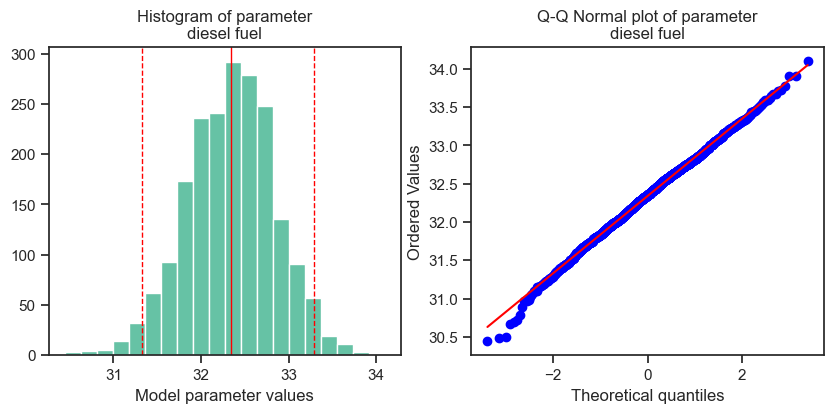

Parameter = gas fuel
Mean = 23.109586783227293
Upper confidence interval = 23.571633661709892
Lower confidence interval = 22.641858523348166


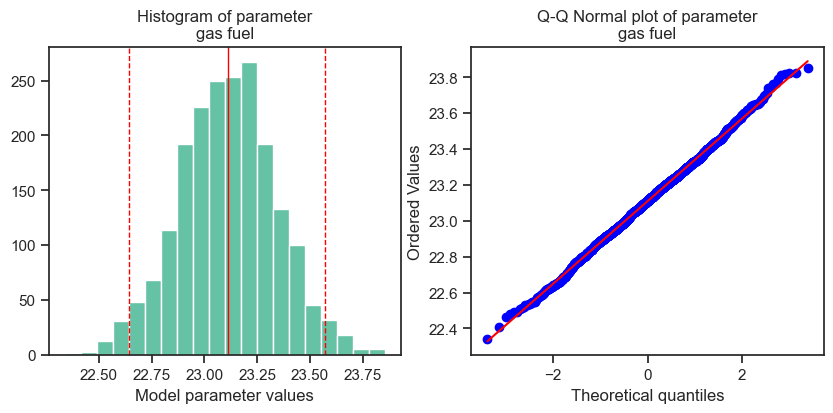

Parameter = curb weight
Mean = -6.398351841498105
Upper confidence interval = -5.825767874585535
Lower confidence interval = -6.974137760502053


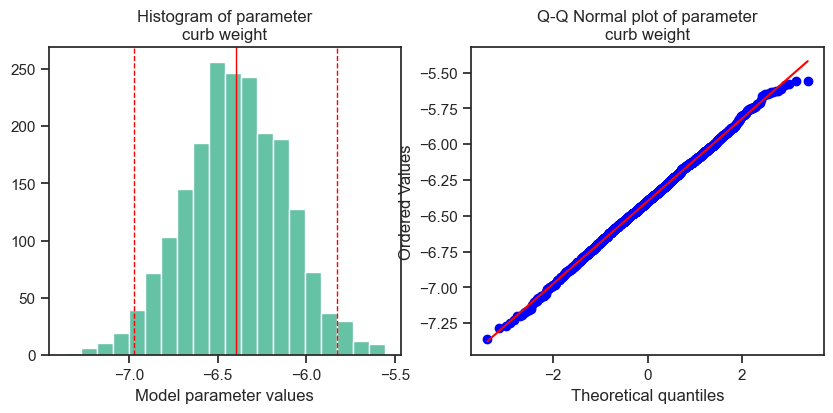

Parameter = curb weight squared
Mean = 1.3066867910912683
Upper confidence interval = 1.6990828790152999
Lower confidence interval = 0.9589599948658432


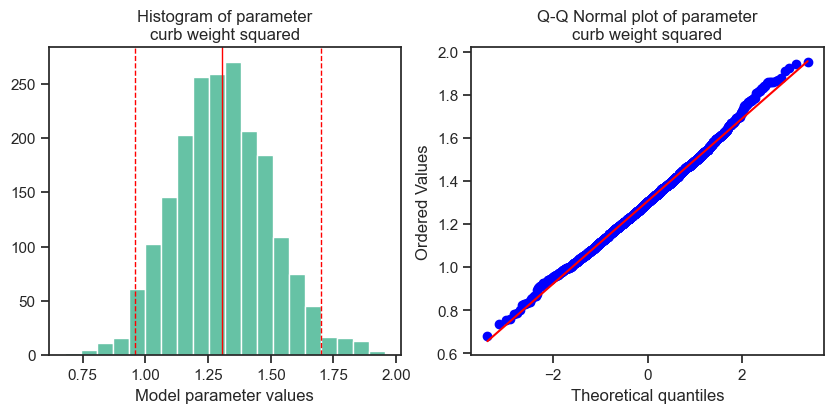

In [49]:
def resample_regression(df, n_boots, n_params=2, formula='y ~ x'):
    ## array to hold the bootstrap samples of the parameters
    boot_samples = np.zeros((n_boots,n_params))
    n_samples = df.shape[0]
    ## Loop over the number of resamples
    for i in range(n_boots):
        ## Create a bootstrap sample of the data frame
        boot_sample = df.sample(n=n_samples, replace=True)
        ## Compute the OLS model
        boot_model = smf.ols(formula=formula, data=boot_sample).fit()
        ## Save the model parameters in the array
        boot_samples[i,:] = boot_model._results.params
    return boot_samples

def compute_CI(values, parameter, p=0.05):   
    mean = np.mean(values)
    p = 100 * p / 2.0
    UCI = np.percentile(values, 100 - p)
    LCI = np.percentile(values, p)
    print('Parameter = ' + parameter)
    print(f'Mean = {mean}')
    print(f'Upper confidence interval = {UCI}')
    print(f'Lower confidence interval = {LCI}')
    return(mean, UCI, LCI)

def plot_boot_params(params, parameter='intercept'):
    mean, UCI, LCI = compute_CI(params, parameter)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ## Plot a histogram
    ax[0].hist(params, bins=20)
    ax[0].axvline(mean, color='red', linewidth=1)
    ax[0].axvline(UCI, color='red', linewidth=1, linestyle='--')
    ax[0].axvline(LCI, color='red', linewidth=1, linestyle='--')
     
    ax[0].set_title('Histogram of parameter\n' + parameter)
    ax[0].set_xlabel('Model parameter values')
    ## Plot the Q-Q Normal plot
    ss.probplot(params, plot = ax[1])
    ax[1].set_title('Q-Q Normal plot of parameter\n' + parameter)
    plt.show()

param_boots = resample_regression(auto_data, 2000, n_params=4, formula=formula)
for i,parameter in enumerate(['diesel fuel', 'gas fuel','curb weight', 'curb weight squared']):  
    plot_boot_params(param_boots[:,i], parameter=parameter)

We can also get a feel for the variability of the model by bootstrap resampling the fit and examining the results. To do so, execute the code in the cell below and examine the results. This code computes and displays 100 samples of the bootstrapped regression fit line. There are two unusual aspects of this code. First, the line plot uses the `hue_order` argument to ensure that line hue corresponds to the correct cases. Second, the bootstrap code in wrapped in a `with` statement to suppress printing the model convergence summary 100 times. Executing the resampling algorithm and displaying the lines with Seaborn may take some time.   

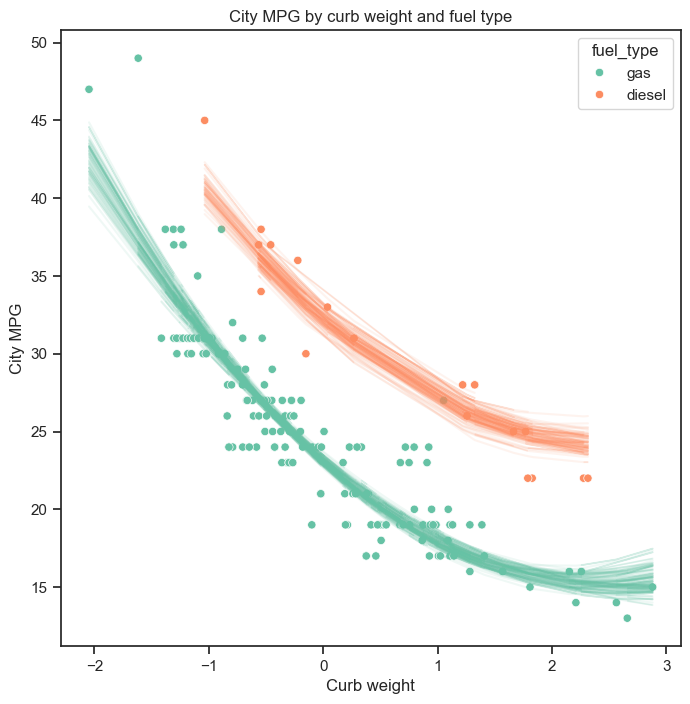

In [50]:
def resample_regression_ols(df, formula,  ax, n_params=4, n_boots=100):
    ## array to hold the bootstrap samples of the parameters
    n_samples = df.shape[0]
    ## Loop over the number of resamples
    for i in range(n_boots):
        ## Create a bootstrap sample of the data frame
        boot_sample = df.sample(n=n_samples, replace=True)
        boot_sample.index = range(len(boot_sample))

        ## Compute the OLS model
        boot_model = smf.ols(formula=formula, data=boot_sample).fit()    
        boot_sample.loc[:,'predicted'] = boot_model.predict(boot_sample)
        sns.lineplot(x='curb_weight', y='predicted', hue='fuel_type', hue_order=['gas','diesel'], data=boot_sample, ax=ax, alpha=0.1, legend=False);

ax = plot_auto()
with contextlib.redirect_stdout(io.StringIO()):
    resample_regression_ols(auto_data, formula,  ax)

There are several observations one can make about these results:    
1. The distribution of the model parameters is generally close to Normal, with a few deviations.      
2. Cis are similar but not identical to the parametric estimates given in the model summary table. The difference being the nonparametric bootstrap estimates make no assumption about the distribution of the model parameters.   
3. The CIs are narrow for the fuel type coefficients, which makes sense since these values represent means that can be estimated with fairly low variance. The CIs for the slope coefficients are relatively wider, particularly for the squared terms, which is expected since slope is more sensitive to random variation in the sample.    
4. The variation in the bootstrap regression lines is reasonably small. As is often the case, the dispersion of the regression lines increases at the ends of the range of the independent variables.     

> **Exercise 22-3:** The results of the `city_mpg_ols` model in Exercise 22-1, included the contrast for the MPG of diesel cars. This contrast value can now be used as an **adjustment factor** for the efficiency of diesel cars.
> The code in the cell below displays the coefficients computed for this model. The second coefficient is the adjustment factor for the efficiency of diesel cars.    

In [51]:
city_mpg_ols._results.params

array([32.36550908, -9.24900594, -6.42798602,  1.30923984])

> To continue with this analysis do the following:     
> 1. Create a new column named `city_mpg_adjusted`. Compute and save the adjusted city MPG into this column.   
> 2. Create a new column named `predicted_adjusted`. Compute and save the adjusted prediction of city MPG into this column.     
> 3. On a single plot display the observations of city mpg vs. standardized curb weight, using `fuel_type` for the hue along with the predictions using `fuel_type` for hue. Make sure you properly lable your plot.    

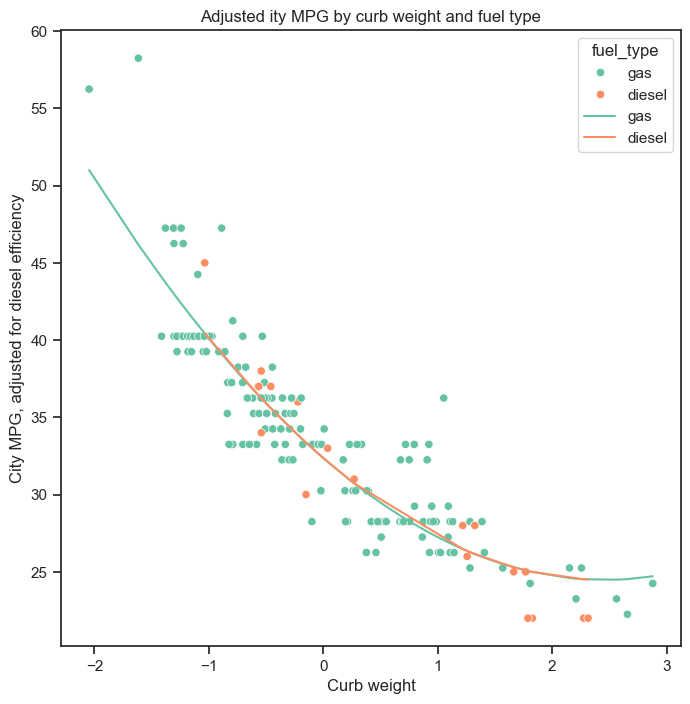

In [52]:
## Put your code below
## Adjust the city_mpg variable for diesel efficiency
diesel_adj = city_mpg_ols._results.params[1]
def diesel_adjust(col, adj, d):
    if d.fuel_type=='diesel':
        return d[col]
    else:
        return d[col] - adj

auto_data['city_mpg_adjusted'] = auto_data.apply(lambda x: diesel_adjust('city_mpg', diesel_adj, x), axis=1)

## Adjust the predictions for diesel efficiency   
auto_data['predicted_adjusted'] = auto_data.apply(lambda x: diesel_adjust('predicted', diesel_adj, x), axis=1)


## Plot the results 
fig,ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='curb_weight', y='city_mpg_adjusted', hue='fuel_type', data=auto_data, ax=ax);
sns.lineplot(x='curb_weight', y='predicted_adjusted', hue='fuel_type', data=auto_data, ax=ax)
ax.set_title('Adjusted ity MPG by curb weight and fuel type');
ax.set_xlabel('Curb weight')
ax.set_ylabel('City MPG, adjusted for diesel efficiency');

> Examine your plot. Does it appear that the adjustment for diesel car efficiency has aligned the observations for diesel and gas cars and why?   

> **Answer:** Yes because we've removed the mean difference in efficiency from all the gas cars, bringing the datasets together.       

## Generalize Linear Model

Until now, we have been working strictly with linear regression models. Linear regression models have a numeric label or response variable. Further, ordinary linear regression assumes the residuals of the model are Normally distributed. 

But, what if the label has another distribution, particularly if the label is categorical? Using a more general form for the label values leads us to the **generalized linear model (GLM)**. Generalized linear model can be constructed for any response variable distribution in the exponential family. The exponential family includes many of the most commonly used probability distributions.    

GLMs are created by observing that for any distribution in the exponential we can define a **link function**. The link function maps a linear model space to the log of the (nonlinear) distribution space. The general form of the link function, $g()$, maps the expected value of the response variable, $y$, given the observation vector, $x$, to a linear model $\hat{\lambda} = \beta_0 + \beta_1\ x$:   

$$g \big( \mathtt{E}[y_i|x_i] \big)  = \hat{\lambda} = \beta_0 + \beta_1\ x$$

To find the value of the response variable we apply the inverse link function:    

$$\mathtt{E}[y_i|x_i]   = g^{-1} \big( \hat{\lambda} \big) = g^{-1} \big( \beta_0 + \beta_1\ x \big) $$

You may well wonder what the link function is for the Normal distribution, which is a member of the exponential family. In this case the link function and the inverse link functions are both unity or 1. This property leads to the ordinary least squares model with a Normally distributed response, we have already investigated.    

### Logistic Regression as a GLM

Now, we will look at a widely used variation of the generalized linear model using a **Binomial distribution**. This method is commonly known as [**logistic regression**](https://en.wikipedia.org/wiki/Logistic_regression). Logistic regression is widely used as a classification model. Logistic regression is linear model, with a binary response or label values, `{False, True}` or `{0, 1}`.  specifically, the response is computed as a log likelihood, leading to a Binomial distribution of the label values. 

The logistic regression algorithm is in the family of [**generalized liner models (GLM)**](https://en.wikipedia.org/wiki/Generalized_linear_model). GLMs use a transformation function to map a nonlinear function of probability to a linear model space, known as a **link function**. The **inverse link function** maps the linear model response to the nonlinear model space. 

To understand the binary response logistic regression as a GLM, we start with a model for the log-odds of response $1$ vs. $0$, given probability of success, or $y_i = 1$, $p_i$. For independent variable vector $x_i$, model parameter vector, $\mathbf{\beta}$, and binary response, $y_i = [0,1]$, we define the link function, know as the or **logit function**:   

$$logit(\mathtt{E}[y_i|x_i]) = logit(p(x_i)) = ln \Big(\frac{p(x_i)}{1-p(x_i)} \Big) =\beta_0 + \mathbf{\beta} 𝑥_i $$

The response of the linear model is transformed to the binomially distributed probability distribution through the **inverse link function**, know as the **inverse logit function**, or **logistic function**. After some algebra we can arrive at:   

\begin{align}
\lambda_i &= \beta_0 + \mathbf{\beta} 𝑥_i\\
p_i = \mathtt{E}[y_i|x_i] &= f(\lambda_i) = logit^{-1}(\lambda_i)  \\
p_i = f(x_i) &= logit^{-1}(\lambda_i) = \frac{1}{1 + e^{-\lambda_i}} = \frac{1}{1 + e^{-(\beta_0 + \mathbf{\beta} 𝑥_i)}}
\end{align}

We can gain an intuitive understanding of these transformations by creating a graph of the simple one-dimensional of the logistic function, or inverse logit function. The one-dimensional logistic function is parameterized by an center, $x_0$, and slope, $\kappa$.   

$$f(x)  = \frac{1}{1 + e^{-\kappa(x - x_0)}}$$

To simplify the example, we set $x_0 =0$ and $\kappa=1$. Execute the code in the cell below to compute and plot an example of the logistic function.

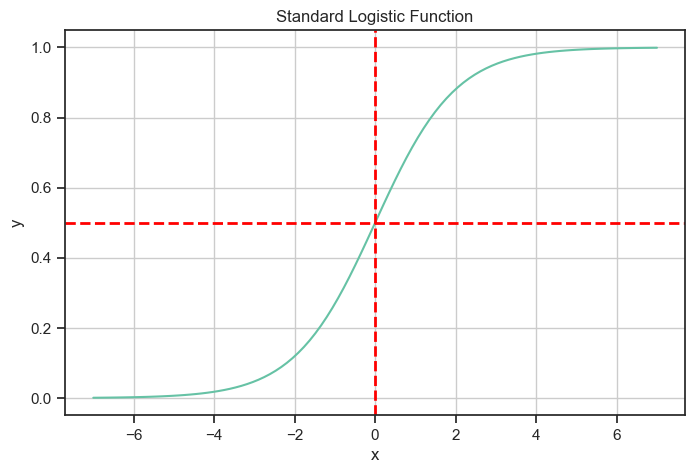

In [53]:
# Plot the logistic transformation function (f(x) above)
x_seq = np.linspace(-7, 7, 100)

def log_fun(x, center=0, scale=1):
    e = np.exp(-scale*(x-center))
    log_out = 1./(1. + e)
    return log_out

log_fun_vectorized = np.vectorize(log_fun)

log_y = log_fun_vectorized(x_seq)

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(x_seq, log_y)
ax.set_title('Standard Logistic Function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.axvline(0, color='red', linewidth=2, linestyle='--')
ax.axhline(0.5, color='red', linewidth=2, linestyle='--')
ax.grid()

You can see that the logistic function crosses the threshold value of $0.5$ at $x=0$. A linear response greater than the threshold gives a model output of 1 and vice versa.        

Let's make this a bit more concrete with a simple example. Say we have a linear model with an intercept, $\beta_0$, and slope parameter, $\beta_1$.

$$\hat{\lambda} = \beta_0 + \beta_1\ x$$

Now, depending on the value of $\hat{y}$ we want to classify the output from a logistic regression model as either `0` or `1`. We can use the linear model in the logistic function as follows:

$$f(\hat{y}) = \frac{1}{1 + e^{-\lambda}} = \frac{1}{1 + e^{-(\beta_0 + \beta_1\ x)}} $$

In this way we transform the continuous output of the linear model defined on $-\infty \le \hat{y} \le \infty$ to a binary response, $0 \le f(\hat{y}) \le 1$ 

### Finding the maximum likelihood solution   

In Chapter 11 we investigated methods for finding maximum likelihood solutions at large scale. These methods are generally based on variations of the stochastic gradient descent (SGD) algorithms or quasi-Newton's methods like the limited memory Broyden–Fletcher–Goldfarb–Shanno (l-BFGS) algorithm. These algorithms are employed routinely to logistic regression problems on a massive scale.     

## What is Deviance?

OLS regression models are often evaluated based on variance ratios, such as the $R^2$ metric, or error metrics like RMSE. However given the nonlinear mapping between the linear model and the response, these methods are not suitable for generalized linear models. The significance of the GLM is expressed in terms of a statistic called **deviance**. It can be a bit of a challenge to wrap your head around what deviance really means. In simple terms, deviance is the difference between the log likelihood of a reference model and some other model. For a model with paramters $f(\phi)$ and a reference model with parameters $f(\phi_r)$, we can write the devaince as:     
$$D \big( f(\mathbf{X},\phi) \big) = 2 \Big( l \big(f(\mathbf{X}, \phi_R) \big) - l \big( f(\mathbf{X}, \phi)\big) \Big)$$    
Where:   
- $\mathbf{X} =$ the array of observations.    
- $l\ \big( f(\mathbf{X}, \phi) \big) = $ the log-likelihood of the model.   

To further complicate the problem there are several commonly used forms of deviance:    
- **Residual deviance** uses a **saturated model** as a referrence. A saturated model has a degree of freedom (parameter) for each observation, leading to a perfect fit.    
- **Residual diviance** uses a **null model** as a reference. A null model explains none of the variance of the data.     

The deviance statistic is $\chi^2$ distributed, and we can apply a significance test on a model.A model with small deviance is little better that informed guessing, and will have a small $\chi^2$ and not be considered a significant improvement. Whereas, a model with large deviance has a large $\chi^2$, demonstrating a significant improvement in accuracy.     

### Residual deviance     

Residual deviance is defined as 2 times the difference between the log likelihood of a saturated model, $f(\mathbf{X}, \phi_S)$, and some other model. We can write can write:      

$$D_R \big( f(\mathbf{X},\phi) \big) = 2 \big( l(f(\mathbf{X}, \phi_S)) - l( f(\mathbf{X}, \phi)\big))$$    

Residual deviance has several important properties.   
- First residual deviance between two identical models must be 0.   
- Second, since the log likelihood of a saturated model will be the maximum possible, $D_R \big( f(\mathbf{X},\phi) \big) \ge 0$.   

What are some simple examples of a saturated model?     

**Normal saturated model:**

We can construct a saturated model for normally distributed values by having a free mean parameter, $u_i$ for each observation, $x_i$.

$$
\begin{bmatrix}
x_1\\
x_2\\
x_3\\
\vdots\\
x_n
\end{bmatrix} = 
\begin{bmatrix}
1, 0, 0, \ldots, 0\\
0, 1, 0, \ldots, 0\\
0, 0, 1, \ldots, 0\\
\vdots,\ \vdots,\ \vdots,\ \ddots,\ \vdots\\
0, 0, 0, \ldots, 1
\end{bmatrix}
\begin{bmatrix}
\mu_1\\
\mu_2\\
\mu_3\\
\vdots\\
\mu_n
\end{bmatrix}
$$

Now, the normal likelihood for this models is   

$$\mathcal{L}(\mathbf{X} |\ \mathbf{\mu}) = -\frac{1}{(2 \pi \sigma^2)^{n/2}} exp\Big[ - \frac{1}{2 \sigma^2}  \sum_{i=1}^n(x_i - \mu_i)^2 \Big]$$

Since $\mu_i = x_i$. The Normal likelihood is $1.0$ and the log likelihood is $0.0$.     

**Binomial saturated model:**

A saturated Binomial model can be constrcuted if for each outcome, $y_i$, with a probability parameter:  

$$ 
\pi_i = 
\begin{cases}
  1 & \text{if $y_i=1$} \\
  0 & \text{if $y_i=0$}
\end{cases}
$$   

The likelihood can be writen:     

$$\prod_{i=1}^{n} \hat{\pi}_i^{y_i} (1 - \hat{\pi}_i)^{1-y_i} = 1^n = 1$$

Since $log(1) = 0$, the log likelihood of the saturated model.     



### Null Deviance    


Null deviance is 2 times the square of the log odds ratio between a model and a null model. Intuitively, the null model is simply informed guessing, and deviance is a measure of how much the model improves accuracy beyond guessing.  

**Binomial null model:**  

To understand binomial deviance, we can start with the expected value of the binomial log-likelihood function:  

$$\hat{l}(k, n | \pi) = log \binom{n}{k} + k\ log(\pi) + (n-k)\ log(1-\pi)$$

We can now construct the log likelihood of the null model, by the simple calculation of the binomial probability:  

$$p_\phi = \bar{y} = \frac{k}{n}$$

For the null model we set $\beta_0 = p_\phi$, so the logistic function for a null model is:    

$$f_{\phi}(\hat{y}) = \frac{1}{1 + e^{-p_{\phi}}} = \frac{1}{1 + e^{-\beta_0}}$$

And with expected log-likelihood:   

$$$\hat{l}_phi(k, n | p_{\phi}) = log \binom{n}{k} + k\ log(p_{\phi}) + (n-k)\ log(1-p_{\phi})$$

We can gain some intuitive understand of the behavior of the null model with an example. Consider the case where half the values of the response, $y$, are 1s. In this case, $p_\phi = n/2 = 0.5$. For each value of $x_i$, the model randomly selects a 1 or a 0 response with probability of 0.5. This model is random guessing and will have an accuracy of 0.5. In other words, the null model is no better in terms of predictive power than just saying that all values of $y$ are either 0 or all values are 1.    

Now that we understand the null model with can state the form of null deviance of a linear model, $logit(p(x_i)) = \beta_0 + \mathbf{\beta} 𝑥_i$, as the log of the square expected likelihood ratio:   

\begin{align}
D(\beta_0 + \mathbf{\beta} 𝑥_i) &= ln \Big( \frac{\hat{L}^2}{\hat{L}_{\phi}^2} \Big) \\
&= 2 \big( \hat{\mathcal{l}}  -  \hat{\mathcal{l}}_{\phi}  \big)
\end{align}

The expected null log-likelihood, $\hat{\mathcal{l}}_{\phi}$, is fixed by the observed response values. Therefore, the better the model, and higher the likelihood, $\hat{\mathcal{l}}$, the higher the deviance and therefore the value of $\chi^2$. Correspondingly, a model with large $\chi^2$ has greater significance and accuracy of predictions.    

In this section, we have focused on the logistic regression problem and binomial log-likelihood. The concepts discussed in this section can be applied to any GLM. In some cases, deviance can be used directly. In other cases log-likelihood ratio is used directly for model evaluation and significance.   

### Evaluation of binary responses

To evaluate models with binary output we can build a **confusion matrix** or **truth table** from counts. These counts are defined:

 - True Positives (TP): Count of cases that are positive and predicted to be positive.
 - True Negatives (TN): Count of cases that are negative and predicted to be negative.
 - False Positives (FP): Count of cases that are negative and predicted to be positive.
 - False Negatives (FN): Count of cases that are positive and predicted to be negative.

The other metrics are defined as follows:

- Accuracy = (TP + TN) / (TP + FP + TN + FN)
- Precision = TP / (TP + FP)
   - Precision is the fraction of the relevant class predictions are actually correct.
- Recall = TP / (TP + FN)
   - Recall is the fraction of the relevant class were we able to predict.

### Logistic Regression Example     

It's time to apply the foregoing theory to a practical problem. The goal for the analysis of the [HR dataset from Kaggle](https://www.kaggle.com/datasets/vjchoudhary7/hr-analytics-case-study) is to help a company identify which employees are most likely to leave. Apparently, these data were generated based on a simulation based on real-world cases. 

> **Exercise 22-4:** To create and evaluate a logistic regression model for the HR data, do the following:      
> 1. Execute the code in the cell below to load the dataset and center some of the independent variables.     

In [57]:
hr_data = pd.read_csv('../data/HR_comma_sep.csv')
for col in ['satisfaction_level','average_montly_hours','last_evaluation']:
    hr_data.loc[:,col] = hr_data.loc[:,col].astype(np.int64) - np.mean(hr_data.loc[:,col]).astype(np.int64)
hr_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.0,0.0,2,-44,3,0,1,0,sales,low
1,0.0,0.0,5,61,6,0,1,0,sales,medium
2,0.0,0.0,7,71,4,0,1,0,sales,medium
3,0.0,0.0,5,22,5,0,1,0,sales,low
4,0.0,0.0,2,-42,3,0,1,0,sales,low


> 2. Define and fit a model for employees leaving using this formula; `'left ~ satisfaction_level + average_montly_hours + last_evaluation + C(salary) + C(promotion_last_5years)'`.   
> 3. Print a summary of the fitted model.    

In [58]:
## Put your code below
formula = 'left ~ satisfaction_level + average_montly_hours + last_evaluation + C(salary) + C(promotion_last_5years)'
hr_glm = smf.ols(formula=formula, data=hr_data).fit()
hr_glm.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   left   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     121.9
Date:                Sun, 27 Oct 2024   Prob (F-statistic):          5.23e-151
Time:                        16:20:32   Log-Likelihood:                -8123.4
No. Observations:               14999   AIC:                         1.626e+04
Df Residuals:                   14992   BIC:                         1.631e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0729      0.012      6.123      0.000       0.050       0.096
C(salary)[T.low]                  0.2203      0.013     17.146      0.000       0.195       0.245
C(salary)[T.medium]               0.1304      0.013     10.078      0.000       0.105       0.156
C(promotion_last_5years)[T.1]    -0.1350      0.024     -5.704      0.000      -0.181      -0.089
satisfaction_level               -0.2445      0.040     -6.168      0.000      -0.322      -0.167
average_montly_hours              0.0006   6.81e-05      8.102      0.000       0.000       0.001
last_evaluation                   0.3362      0.025     13.441      0.000       0.287       0.385
==============================================================================
Omnibus:                     2399.566   Durbin-Watson:                   0.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3456.626
Skew:                           1.155   Prob(JB):                         0.00
Kurtosis:                       2.557   Cond. No.                         583.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> 4. The prediction from the model are **binomial probabilities**. Execute the code in the cell below to compute and display these probabilities. The code displays the first 5 rows of the prediction probability along with a histogram of the probabilities for all cases and a violin plot by leaving status.    

Probabilities of leaving:
   predicted_prob  left
0        0.268905     1
1        0.236966     1
2        0.242484     1
3        0.305327     1
4        0.270009     1
5        0.266698     1


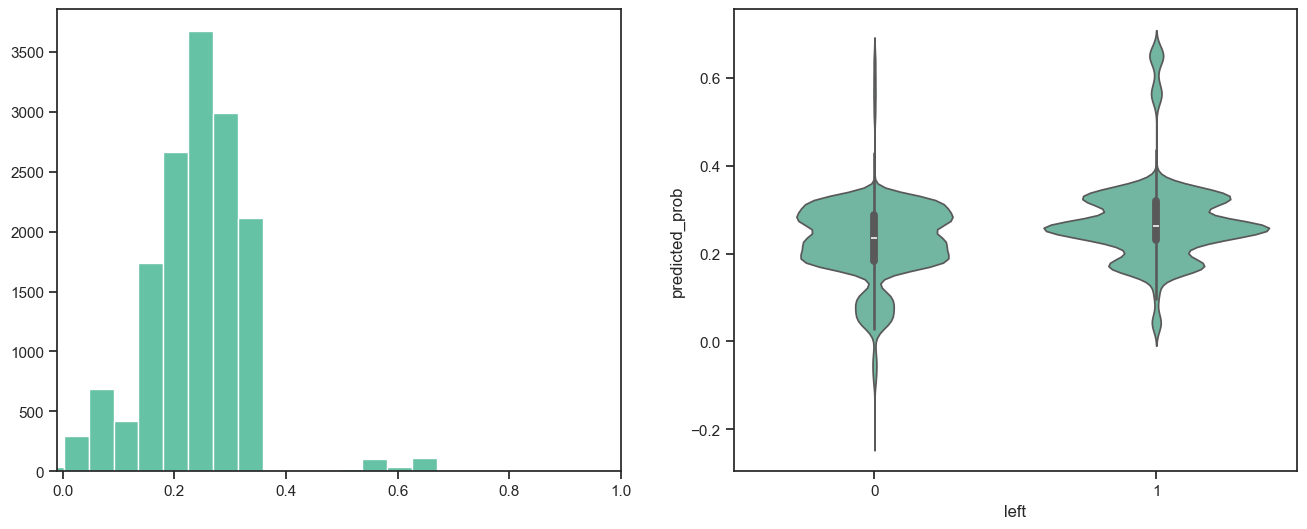

In [59]:
hr_data.loc[:,'predicted_prob'] = hr_glm.predict(hr_data)
print('Probabilities of leaving:')
print(hr_data.loc[:5,['predicted_prob', 'left']])

fig,ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].hist(hr_data.loc[:,'predicted_prob'], bins=20)
ax[0].set_xlim(-0.01,1.0)
sns.violinplot(x='left', y='predicted_prob', data=hr_data, ax=ax[1])
plt.show()

> 5. The final step is to set a threshold and convert these probabilities to binary output, $[0,1]$ or $[leave,stay]$. The threshold is selected by examining the above plots, and then a bit of experimentation (hyperparameter search) to find a reasonable trade-off between precision and recall. To do so and display model performance metrics, execute the code in the cell below.  

In [60]:
threshold = 0.35
hr_data.loc[:,'predicted'] = np.where(hr_data.loc[:,'predicted_prob'] > threshold, 1, 0)
print('\n\nPrediction of leaving:')
print(hr_data.loc[:5,'predicted'])

print('\nConfusion Matrix')
Confusion_Matrix = metrics.confusion_matrix(hr_data.loc[:,'left'], hr_data.loc[:,'predicted'])
accuracy = metrics.accuracy_score(hr_data.loc[:,'left'], hr_data.loc[:,'predicted'])#(Confusion_Matrix[1,1] +  Confusion_Matrix[0,0])/np.sum(Confusion_Matrix)
precision = metrics.precision_score(hr_data.loc[:,'left'], hr_data.loc[:,'predicted'])
recall = metrics.recall_score(hr_data.loc[:,'left'], hr_data.loc[:,'predicted'])
Confusion_Matrix = pd.DataFrame(Confusion_Matrix, index=['True Stay', 'True Leave'], columns = ['Predicted Stay', 'Predicted Leaving'])
print(Confusion_Matrix)
print(f"\nAccuracy = {round(accuracy, 3)}")
print(f"Precision = {round(precision, 3)}")
print(f"Recall = {round(recall, 3)}")



Prediction of leaving:
0    0
1    0
2    0
3    0
4    0
5    0
Name: predicted, dtype: int64

Confusion Matrix
            Predicted Stay  Predicted Leaving
True Stay            11314                114
True Leave            3330                241

Accuracy = 0.77
Precision = 0.679
Recall = 0.067


> Examine the results and answer these questions:    
> 1. Keeping in mind that a lower linear response corresponds to a lower probability of leaving the company, examine the model coefficients. Do the signs of these coefficient make sense and why?       
> 2. Examine the histogram of the probabilities. Keeping in mind that most employees do not leave the company, describe key properties of this distribution and how they relate to predicting leaving.               
> 3. Examine the confusion matrix (truth table) and the performance metrics. Do these metrics indicate the model effectively predicts people leaving the company and if not why not?          

> **Answers:**   
> 1. Yes the signs make sense since the lower probability is the probability of leaving the company and the expected positive traits have negative coefficients, meaning those dependent variables being higher makes an employee more likely to stay and vice versa for the positive coefficients. For example, the greatest magnitude negative coefficient is satisfaction level, which obviously attributes to someone's want to stay or not, and the more satisfied they are, the less likely they are to leave.         
> 2. Looking at the histogram, it appears the greatest number of employees have about a 25% probability of leaving, with most of the employees being plus or minus 15% from that majority. The probability of leaving sharply drops off to at or near no employees at around 35% probability with some small bumps around 60%. These values show that most employees are at or below 25% chance of leaving the company and nearly all are below ~35% chance of leaving, with a couple outliers with greater probability.       
> 3. Our precision and accuracy is good, so we're good at predicting if people will stay with the company (true positives), but we have very weak recall, which is our ability to predict if people are leaving the company. So our model is not great at predicting if people are leaving the company. Some adjustment of our thresholds could improve this balance.            

## GLM Example; Poisson Regression    

We will now apply a GLM to a Poisson regression example. Poisson regression is another example of a nonlinear response model. Along with some other distributions, Poisson regression is supported in many software packages, including [StatsModels Generalied Linear Models (GLM)](https://www.statsmodels.org/stable/glm.html) and Scikit-Learn [Generalized-linear-regression](https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-regression). Examination of this documentation shows a number of built in link functions and inverse link functions. Creating link functions for other distributions is supported as well.   

Recalling that the Poisson distribution has an exponential form with a single parameter, $\lambda$. The parameter, $\lambda$, is the expected arrival rate of the process. The predictions, $y$, given the observations, $x$ and the model parameter, $\lambda$, can then be written:      

$$log \big[ \mathtt{E}(y | x) \big] = x \lambda \Longleftrightarrow \mathtt{E}(y | x) = e^{x \lambda }$$

We can extend this relationship by using a linear model for $\lambda$, so that so that the expected arrival rate changes with the independent variables. For example, for a linear model with intercept, $\beta_0$, and $p$ dimensional slope parameter vector, $\vec{\beta}$. The Poisson regression estimate of $\lambda_i$, for a $p$ dimensional observation vector $\mathbf{x}_i $ is then:     

$$log(\lambda_i) = \beta_0 + \mathbf{x}_i \vec{\beta} \Longleftrightarrow \lambda_i = e^{(\beta_0 + \mathbf{x}_i $\vec{\beta})}$$

We can now use the above relations in the formulation of the Poisson distribution to find the link function ($e^{x_i \lambda_i }$) and inverse link function:   

\begin{align}
log \big[ \mathtt{E}(y_i |x_i) \big] = x_i \lambda_i &\Longleftrightarrow \mathtt{E}(y_ | x_i) = e^{x_i \lambda_i } \\
log \big[ \mathtt{E}(y_i |x_i) \big] = \beta_0 + \mathbf{x}_i \vec{\beta} &\Longleftrightarrow \mathtt{E}(y_ | x_i) = e^{\beta_0 + \mathbf{x}_i \vec{\beta} }
\end{align}

### Poisson regression example    

It is time to try and example. We will work with a dataset for the number (arrival in Poisson regression terms) of awards for high school students in three different academic programs. There are two independent variables, the program and the student's standardized math test score. These data are from the [UCLA Advanced Research Computing, Statistical Methods and Data Analytics](https://stats.oarc.ucla.edu/r/dae/poisson-regression/#:~:text=Examples%20of%20Poisson%20regression,the%20course%20of%2020%20years) group. Since the dependent variable is a count, number of awards, this problem is a candidate to try Poisson regression.     

Now, run th code in the cell below to load the dataset, prepare the values, and display the first few lines.   

In [61]:
program_codes = {1:'General', 2:'Academic', 3:'Vocational'}
award_scores = pd.read_csv("https://stats.idre.ucla.edu/stat/data/poisson_sim.csv")
award_scores.loc[:,'prog'] = award_scores.loc[:,'prog'].replace(program_codes)
award_scores.head(10)

/var/folders/yx/p_q7lg1d7l9gxgp19507kcr00000gr/T/ipykernel_87442/4034354479.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Vocational' 'General' 'Vocational' 'Vocational' 'Vocational' 'General'
 'Vocational' 'Vocational' 'Vocational' 'Vocational' 'Vocational'
 'Academic' 'Vocational' 'Vocational' 'Vocational' 'General' 'General'
 'Vocational' 'Academic' 'Vocational' 'General' 'Vocational' 'Vocational'
 'Vocational' 'Academic' 'Academic' 'General' 'General' 'Academic'
 'Academic' 'General' 'Vocational' 'Academic' 'Academic' 'Vocational'
 'Vocational' 'Vocational' 'Academic' 'General' 'Academic' 'General'
 'Academic' 'Academic' 'Vocational' 'Academic' 'Vocational' 'Vocational'
 'General' 'Vocational' 'Academic' 'Academic' 'Vocational' 'General'
 'Academic' 'Academic' 'General' 'Academic' 'General' 'Vocational'
 'General' 'Vocational' 'Academic' 'Academic' 'Vocational' 'Vocational'
 'Vocational' 'General' 'Acad

,id,num_awards,prog,math
0,45,0,Vocational,41
1,108,0,General,41
2,15,0,Vocational,44
3,67,0,Vocational,42
4,153,0,Vocational,40
5,51,0,General,42
6,164,0,Vocational,46
7,133,0,Vocational,40
8,2,0,Vocational,33
9,53,0,Vocational,46


To get a feel from these data, execute the code in the cell below to examine the courts of awards by program type.  

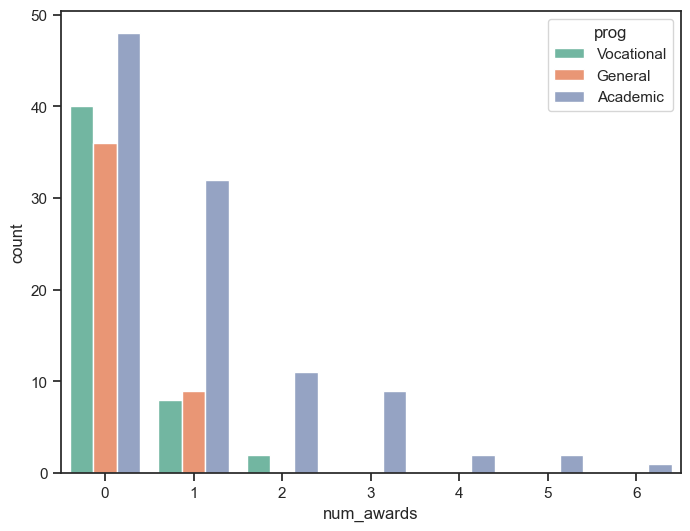

In [62]:
fig,ax = plt.subplots(figsize=(8,6))
sns.countplot(data=award_scores, x='num_awards',hue='prog', ax=ax);

As you can see, most students receive no awards, with a small number receiving up to 6.  

> **Exercise 22-5:** You will now construct and evaluate a Poisson regression model for these count data by these steps:    
> 1. Using [statsmodels.formula.api.poisson](https://www.statsmodels.org/dev/generated/statsmodels.formula.api.poisson.html) define and fit a model using the formula `'num_awards ~ math + C(prog)'`.   
> 2. Display the summary of the model.   

In [63]:
## Put your code below
formula = 'num_awards ~ math + C(prog)'
poisson_glm = smf.poisson(formula=formula, data=award_scores).fit()
poisson_glm.summary()


Optimization terminated successfully.
         Current function value: 0.913761
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:             num_awards   No. Observations:                  200
Model:                        Poisson   Df Residuals:                      196
Method:                           MLE   Df Model:                            3
Date:                Sun, 27 Oct 2024   Pseudo R-squ.:                  0.2118
Time:                        16:38:19   Log-Likelihood:                -182.75
converged:                       True   LL-Null:                       -231.86
Covariance Type:            nonrobust   LLR p-value:                 3.747e-21
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -4.1633      0.663     -6.281      0.000      -5.462      -2.864
C(prog)[T.General]       -1.0839      0.358     -3.025      0.002      -1.786      -0.382
C(prog)[T.Vocational]    -0.7140      0.320     -2.231      0.026      -1.341      -0.087
math                      0.0702      0.011      6.619      0.000       0.049       0.091
=========================================================================================
"""

> 3. Execute the code in the cell below to display a plot of the data and the fitted regression lines.   

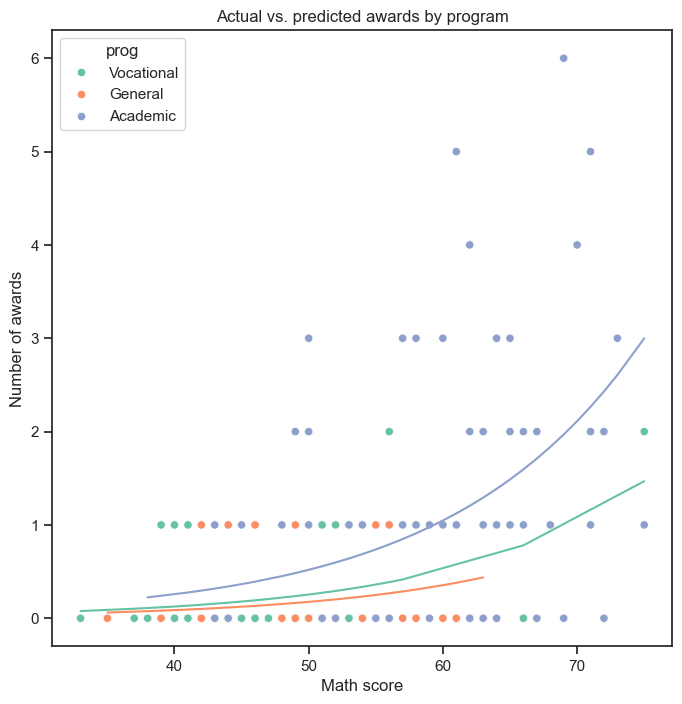

In [64]:
award_scores['predicted'] = poisson_glm.predict(award_scores)

fig,ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='math', y='num_awards', hue='prog', data=award_scores, ax=ax);
sns.lineplot(x='math', y='predicted', hue='prog', data=award_scores, ax=ax, legend=False);
ax.set_title('Actual vs. predicted awards by program');
ax.set_xlabel('Math score');
ax.set_ylabel('Number of awards');

> 4. The next question is how variable are the parameter estimates? To find out, execute the code in the cell below to find the bootstrap distributions of the model parameters.     

/Users/hendwi1/Documents/workspace/harvard/CSCI-E-83/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hendwi1/Documents/workspace/harvard/CSCI-E-83/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Parameter = Intercept
Mean = -4.175911600739911
Upper confidence interval = -2.8795557308310857
Lower confidence interval = -5.625473839967316


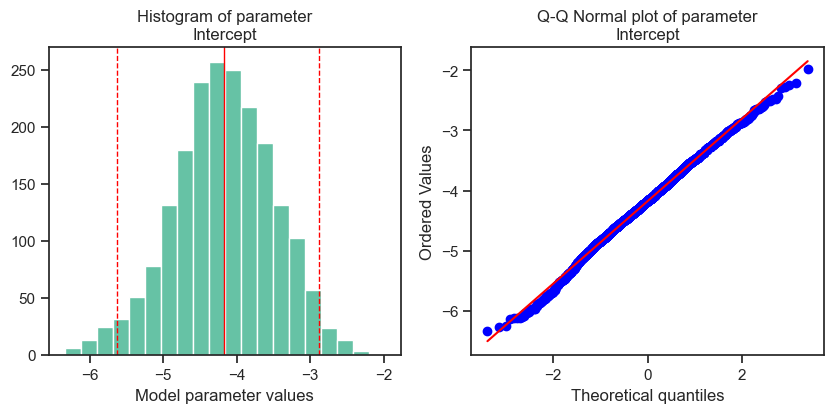

Parameter = General
Mean = -1.156704244463144
Upper confidence interval = -0.510810083730124
Lower confidence interval = -1.8803198608622071


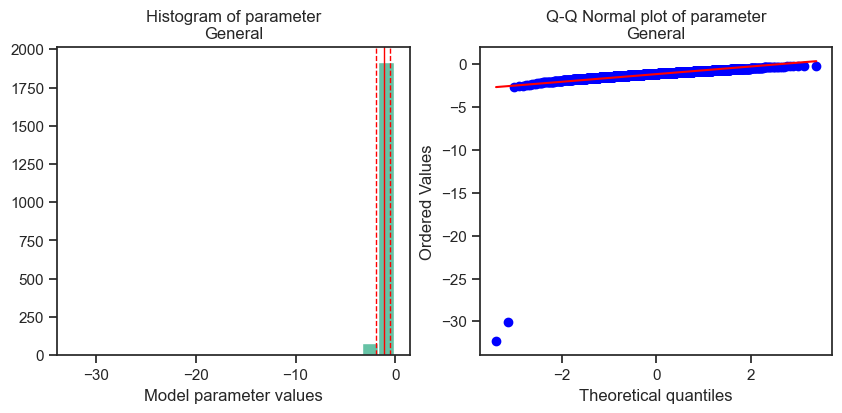

Parameter = Vocational
Mean = -0.7611019602097476
Upper confidence interval = -0.19510169568067381
Lower confidence interval = -1.5121083293390865


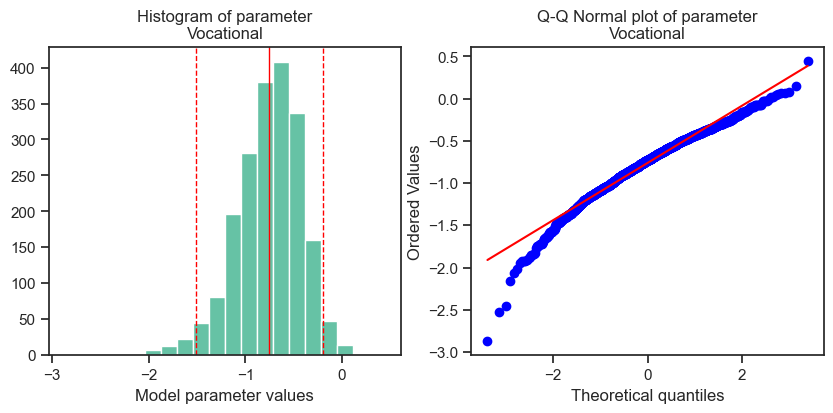

Parameter = Math
Mean = 0.07025248645718421
Upper confidence interval = 0.09282442268522524
Lower confidence interval = 0.04865664350137461


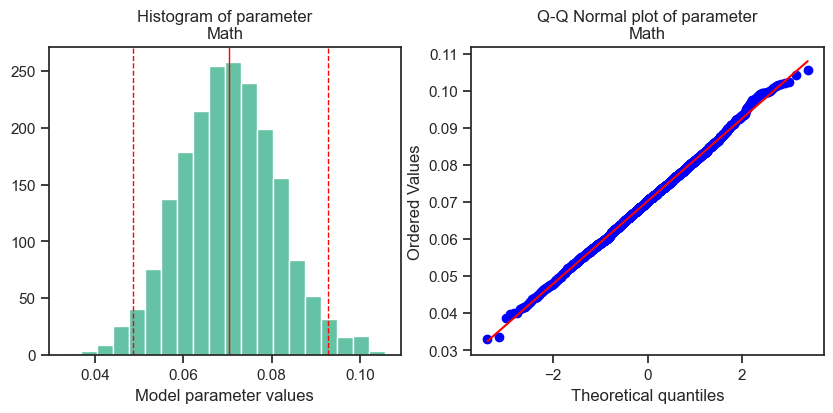

In [65]:
import contextlib
import io

def resample_regression_poisson(df, n_boots, n_params=2, formula='y ~ x', simulate=False):
    ## array to hold the bootstrap samples of the parameters
    boot_samples = np.zeros((n_boots,n_params))
    n_samples = df.shape[0]
    ## Loop over the number of resamples
    for i in range(n_boots):
        ## Create a bootstrap sample of the data frame
        boot_sample = df.sample(n=n_samples, replace=True)
        ## Compute the OLS model
        boot_model = smf.poisson(formula=formula, data=boot_sample).fit()
        ## Save the model parameters in the array
        boot_samples[i,:] = boot_model._results.params
        if simulate:
            df 
    return boot_samples


with contextlib.redirect_stdout(io.StringIO()):
    poisson_param_boots = resample_regression_poisson(award_scores, 2000, n_params=4, formula=formula)
for i,parameter in enumerate(['Intercept', 'General','Vocational', 'Math']):  
    plot_boot_params(poisson_param_boots[:,i], parameter=parameter)

> 5. Finally you can get a feel for the variability of the regression predictions by bootstrapping plotting the regression lines. Execute the code in the cell below and examine the results. The bootstrap resampling and display of the line plots with Seaborn will take some time.      

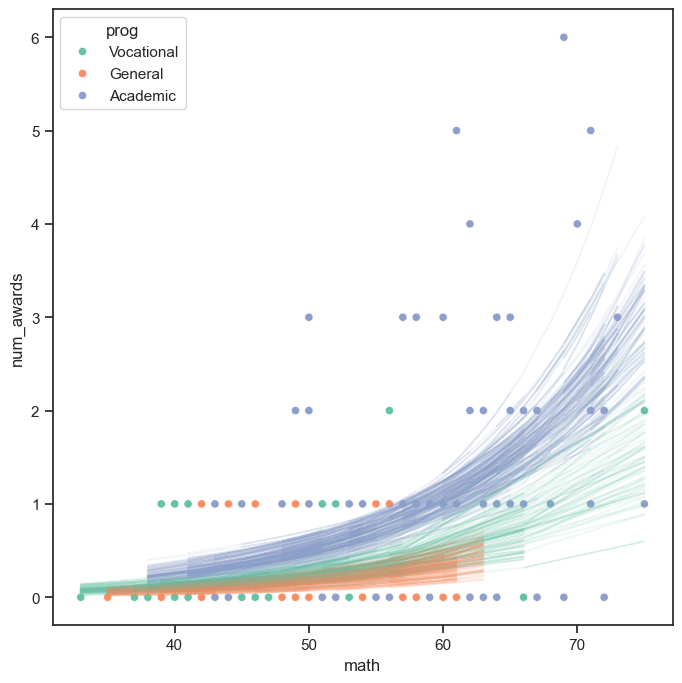

In [66]:
def resample_regression_poisson(df, formula,  ax, n_params=4, n_boots=100):
    ## array to hold the bootstrap samples of the parameters
    boot_samples = np.zeros((n_boots,n_params))
    n_samples = df.shape[0]
    ## Loop over the number of resamples
    for i in range(n_boots):
        ## Create a bootstrap sample of the data frame
        boot_sample = df.sample(n=n_samples, replace=True)
        boot_sample.index = range(len(boot_sample))

        ## Compute the OLS model
        boot_model = smf.poisson(formula=formula, data=boot_sample).fit()    
        boot_sample.loc[:,'predicted'] = boot_model.predict(boot_sample)
        sns.lineplot(x='math', y='predicted', hue='prog', hue_order=['Vocational','General', 'Academic'], data=boot_sample, ax=ax, alpha=0.1, legend=False);
        ## Save the model parameters in the array
        boot_samples[i,:] = boot_model._results.params
    return boot_samples

fig,ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='math', y='num_awards', hue='prog', data=award_scores, ax=ax);
with contextlib.redirect_stdout(io.StringIO()):
    resample_regression_poisson(award_scores, formula,  ax)

> Examine the result and answer the following questions:     
> 1. Examine the distributions of the the model coefficients. How can you describe the distributions with respect to how close they are or not close to Normal?        
> 2. Next consider the bootstrap regression lines, keeping in mind that based on the regression model the value of the expected arrival rate parameter, $\lambda$ increases with the value of `math`, and that $\lambda$ is also the variance. How can you explain the increasing dispersion of the regression lines toward the right of the plot above?   
> 3. Given the dispersion of the regression lines, what are some reasonable inferences you can make and why?         

> **Answers:**    
> 1. All the coefficients are pretty close to normal in the first two quartiles in either direction, but General had a couple large outliers and Vocational really fell away from normal after the second quartiles, especially in the negative direction.        
> 2. I would appear the increase in dispersion toward the right of the plot is due to the increase in num_awards as math increases but not all high math values had high num_awards, so the bootstrapped regressions spread as their choices vary.          
> 3. A reasonable inference that couple be made from the regression line dispersion is that higher math values tend to mean an increase in num_awards, but it's no guarantee and there may be another indicator that could be added to better predict the number of awards more precisely.        

#### Copyright 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024 Stephen F Elston. All rights reserved. 